In [1]:
# Uninstall the current version of Polars
!pip uninstall polars -y

# Install a specific version of Polars (e.g., 0.18.10)
!pip install polars==0.19.2 --no-cache-dir --force-reinstall

# Verify the installed version
import polars as pl
print(f"Polars version installed: {pl.__version__}")

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 75.0 MB/s eta 0:00:00a 0:00:01
Polars version installed: 0.19.2


In [2]:
import polars as pl

# Create a sample DataFrame
df = pl.DataFrame({"col1": [1, 2, 3, 4, 5]})

# Convert to LazyFrame
lazy_df = df.lazy()

# Get and print all available methods for LazyFrame
methods = dir(lazy_df)

# Optionally, print methods to see them all
print(methods)

['__annotations__', '__bool__', '__class__', '__contains__', '__copy__', '__dataframe_consortium_standard__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_accessors', '_comparison_error', '_from_pyldf', '_ldf', '_repr_html_', '_scan_csv', '_scan_ipc', '_scan_ndjson', '_scan_parquet', '_scan_python_function', 'approx_n_unique', 'approx_unique', 'bottom_k', 'cache', 'cast', 'clear', 'clone', 'collect', 'collect_async', 'columns', 'deserialize', 'drop', 'drop_nulls', 'dtypes', 'explain', 'explode', 'fetch', 'fill_nan', 'fill_null', 'filter', 'first', 'from_json', 'group_by', 'group_by_dynamic', 'group_by_rolling', 'groupby', 'groupby_dynamic', 

In [8]:
!pip install numpy
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 4.9 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl
import datetime
from tqdm import tqdm

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# These are variables to be used by the score function
column_names = {
    'series_id_column_name': 'series_id',
    'time_column_name': 'step',
    'event_column_name': 'event',
    'score_column_name': 'score',
}

tolerances = {
    'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
    'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
}

In [2]:
print(f"Polars version installed: {pl.__version__}")

Polars version installed: 0.19.2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

## Importing data

In [4]:
# Importing data

# Column transformations

dt_transforms = [
    pl.col('timestamp').str.to_datetime(),
    (pl.col('timestamp').str.to_datetime().dt.year()-2000).cast(pl.UInt8).alias('year'),
    pl.col('timestamp').str.to_datetime().dt.month().cast(pl.UInt8).alias('month'),
    pl.col('timestamp').str.to_datetime().dt.day().cast(pl.UInt8).alias('day'),
    pl.col('timestamp').str.to_datetime().dt.hour().cast(pl.UInt8).alias('hour')
]

data_transforms = [
    pl.col('anglez').cast(pl.Int16), # Casting anglez to 16 bit integer
    (pl.col('enmo')*1000).cast(pl.UInt16), # Convert enmo to 16 bit uint
]

train_series = pl.scan_parquet('train_series.parquet').with_columns(
    dt_transforms + data_transforms
    )

train_events = pl.read_csv('train_events.csv').with_columns(
    dt_transforms
    ).drop_nulls()

test_series = pl.scan_parquet('test_series.parquet').with_columns(
    dt_transforms + data_transforms
    )

# Removing null events and nights with mismatched counts from series_events
mismatches = train_events.drop_nulls().group_by(['series_id', 'night']).agg([
    ((pl.col('event') == 'onset').sum() == (pl.col('event') == 'wakeup').sum()).alias('balanced')
    ]).sort(by=['series_id', 'night']).filter(~pl.col('balanced'))

for mm in mismatches.to_numpy():
    train_events = train_events.filter(~((pl.col('series_id') == mm[0]) & (pl.col('night') == mm[1])))

# Getting series ids as a list for convenience
series_ids = train_events['series_id'].unique(maintain_order=True).to_list()

# Updating train_series to only keep these series ids
train_series = train_series.filter(pl.col('series_id').is_in(series_ids))

In [5]:
features, feature_cols = [pl.col('hour')], ['hour']

for mins in [5, 30, 60*2, 60*8] :

    for var in ['enmo', 'anglez'] :

        features += [
            pl.col(var).rolling_mean(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'{var}_{mins}m_mean'),
            pl.col(var).rolling_max(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'{var}_{mins}m_max'),
            pl.col(var).rolling_std(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'{var}_{mins}m_std')
        ]

        feature_cols += [
            f'{var}_{mins}m_mean', f'{var}_{mins}m_max', f'{var}_{mins}m_std'
        ]

        # Getting first variations
        features += [
            (pl.col(var).diff().abs().rolling_mean(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_mean'),
            (pl.col(var).diff().abs().rolling_max(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_max'),
            (pl.col(var).diff().abs().rolling_std(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_std')
        ]

        feature_cols += [
            f'{var}_1v_{mins}m_mean', f'{var}_1v_{mins}m_max', f'{var}_1v_{mins}m_std'
        ]

id_cols = ['series_id', 'step', 'timestamp']

train_series = train_series.with_columns(
    features
).select(id_cols + feature_cols)

test_series = test_series.with_columns(
    features
).select(id_cols + feature_cols)

In [6]:
def make_train_dataset(train_data, train_events, drop_nulls=False) :

    series_ids = train_data['series_id'].unique(maintain_order=True).to_list()
    X, y = pl.DataFrame(), pl.DataFrame()
    for idx in tqdm(series_ids) :

        # Normalizing sample features
        sample = train_data.filter(pl.col('series_id')==idx).with_columns(
            [(pl.col(col) / pl.col(col).std()).cast(pl.Float32) for col in feature_cols if col != 'hour']
        )

        events = train_events.filter(pl.col('series_id')==idx)

        if drop_nulls :
            # Removing datapoints on dates where no data was recorded
            sample = sample.filter(
                pl.col('timestamp').dt.date().is_in(events['timestamp'].dt.date())
            )

        X = X.vstack(sample[id_cols + feature_cols])

        onsets = events.filter((pl.col('event') == 'onset') & (pl.col('step') != None))['step'].to_list()
        wakeups = events.filter((pl.col('event') == 'wakeup') & (pl.col('step') != None))['step'].to_list()

        # NOTE: This will break if there are event series without any recorded onsets or wakeups
        y = y.vstack(sample.with_columns(
            sum([(onset <= pl.col('step')) & (pl.col('step') <= wakeup) for onset, wakeup in zip(onsets, wakeups)]).cast(pl.Boolean).alias('asleep')
            ).select('asleep')
            )

    y = y.to_numpy().ravel()

    return X, y

In [7]:
def get_events(series, classifier) :
    '''
    Takes a time series and a classifier and returns a formatted submission dataframe.
    '''

    series_ids = series['series_id'].unique(maintain_order=True).to_list()
    events = pl.DataFrame(schema={'series_id':str, 'step':int, 'event':str, 'score':float})

    for idx in tqdm(series_ids) :

        # Collecting sample and normalizing features
        scale_cols = [col for col in feature_cols if (col != 'hour') & (series[col].std() !=0)]
        X = series.filter(pl.col('series_id') == idx).select(id_cols + feature_cols).with_columns(
            [(pl.col(col) / series[col].std()).cast(pl.Float32) for col in scale_cols]
        )

        # Applying classifier to get predictions and scores
        preds, probs = classifier.predict(X[feature_cols]), classifier.predict_proba(X[feature_cols])[:, 1]

        #NOTE: Considered using rolling max to get sleep periods excluding <30 min interruptions, but ended up decreasing performance
        X = X.with_columns(
            pl.lit(preds).cast(pl.Int8).alias('prediction'),
            pl.lit(probs).alias('probability')
                        )

        # Getting predicted onset and wakeup time steps
        pred_onsets = X.filter(X['prediction'].diff() > 0)['step'].to_list()
        pred_wakeups = X.filter(X['prediction'].diff() < 0)['step'].to_list()

        if len(pred_onsets) > 0 :

            # Ensuring all predicted sleep periods begin and end
            if min(pred_wakeups) < min(pred_onsets) :
                pred_wakeups = pred_wakeups[1:]

            if max(pred_onsets) > max(pred_wakeups) :
                pred_onsets = pred_onsets[:-1]

            # Keeping sleep periods longer than 30 minutes
            sleep_periods = [(onset, wakeup) for onset, wakeup in zip(pred_onsets, pred_wakeups) if wakeup - onset >= 12 * 30]

            for onset, wakeup in sleep_periods :
                # Scoring using mean probability over period
                score = X.filter((pl.col('step') >= onset) & (pl.col('step') <= wakeup))['probability'].mean()

                # Adding sleep event to dataframe
                events = events.vstack(pl.DataFrame().with_columns(
                    pl.Series([idx, idx]).alias('series_id'),
                    pl.Series([onset, wakeup]).alias('step'),
                    pl.Series(['onset', 'wakeup']).alias('event'),
                    pl.Series([score, score]).alias('score')
                ))

    # Adding row id column
    events = events.to_pandas().reset_index().rename(columns={'index':'row_id'})

    return events

In [8]:
print(train_series.schema)

{'series_id': Utf8, 'step': UInt32, 'timestamp': Datetime(time_unit='us', time_zone=None), 'hour': UInt8, 'enmo_5m_mean': UInt16, 'enmo_5m_max': UInt16, 'enmo_5m_std': UInt16, 'enmo_1v_5m_mean': UInt32, 'enmo_1v_5m_max': UInt32, 'enmo_1v_5m_std': UInt32, 'anglez_5m_mean': UInt16, 'anglez_5m_max': UInt16, 'anglez_5m_std': UInt16, 'anglez_1v_5m_mean': UInt32, 'anglez_1v_5m_max': UInt32, 'anglez_1v_5m_std': UInt32, 'enmo_30m_mean': UInt16, 'enmo_30m_max': UInt16, 'enmo_30m_std': UInt16, 'enmo_1v_30m_mean': UInt32, 'enmo_1v_30m_max': UInt32, 'enmo_1v_30m_std': UInt32, 'anglez_30m_mean': UInt16, 'anglez_30m_max': UInt16, 'anglez_30m_std': UInt16, 'anglez_1v_30m_mean': UInt32, 'anglez_1v_30m_max': UInt32, 'anglez_1v_30m_std': UInt32, 'enmo_120m_mean': UInt16, 'enmo_120m_max': UInt16, 'enmo_120m_std': UInt16, 'enmo_1v_120m_mean': UInt32, 'enmo_1v_120m_max': UInt32, 'enmo_1v_120m_std': UInt32, 'anglez_120m_mean': UInt16, 'anglez_120m_max': UInt16, 'anglez_120m_std': UInt16, 'anglez_1v_120m_mea

## Training Models

In [12]:
import polars as pl

# Create a LazyFrame
lazy_df = pl.LazyFrame({"col1": [1, 2, 3, 4, 5]})

# Check for 'gather_every' method
print("gather_every" in dir(lazy_df))

False


In [9]:
'''
from sklearn.model_selection import train_test_split

train_ids, val_ids = train_test_split(series_ids, train_size=0.7, random_state=42)

# We will collect datapoints at 10 minute intervals for training for validating
train_data = train_series.filter(pl.col('series_id').is_in(train_ids)).take_every(12 * 10).collect()

val_data = train_series.filter(pl.col('series_id').is_in(val_ids)).collect()
val_solution = train_events.filter(pl.col('series_id').is_in(val_ids)).select(['series_id', 'event', 'step']).to_pandas()
'''

# Collecting datapoints at every 5 minutes
train_data = train_series.filter(pl.col('series_id').is_in(series_ids)).take_every(12 * 5).collect()
# Collecting datapoints at every 5 minutes
#train_data = train_series.filter(pl.col('series_id').is_in(series_ids)).collect().gather_every(12 * 5)




In [10]:
# Creating train dataset
X_train, y_train = make_train_dataset(train_data, train_events)

100%|███████████████████████████████████████████████████████████████| 269/269 [00:03<00:00, 75.84it/s]


### Training and validating random forest

In [11]:
print(y_train)

[False False False ... False False False]


In [13]:
from xgboost import XGBClassifier

# Creating XGBoost classifier
xgb_classifier = XGBClassifier(
    n_estimators=100,        # Number of boosting rounds
    learning_rate=0.05,      # Learning rate
    max_depth=10,            # Maximum depth of a tree
    random_state=42,         # For reproducibility
    n_jobs=-1,               # Use all available CPU cores
)

# Training the XGBoost classifier
xgb_classifier.fit(X_train[feature_cols], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [16]:
train_score = xgb_classifier.score(X_train[feature_cols], y_train)
print(f"Training Accuracy: {train_score}")

Training Accuracy: 0.9764868523261269


In [ ]:
%matplotlib inline

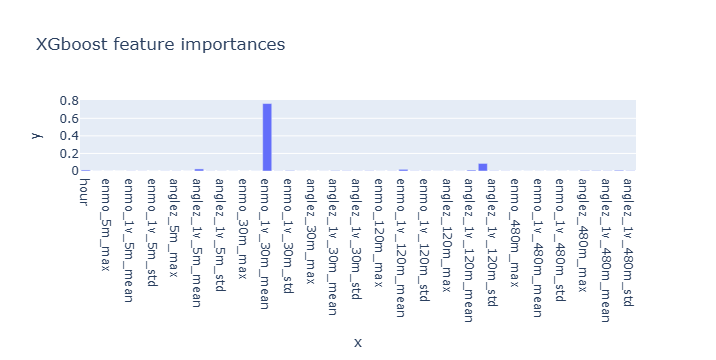

In [17]:
# Plotting feature importances
fig = px.bar(x=feature_cols,
       y=xgb_classifier.feature_importances_,
       title='XGboost feature importances'
      )
fig.show()

In [ ]:
# Checking performance on validation set
#rf_submission = get_events(val_data, rf_classifier)

#print(f"Random forest score: {score(val_solution, rf_submission, tolerances, **column_names)}")

In [19]:
# Saving classifier
import pickle
with open('xgb_classifier_final.pkl', 'wb') as f:
    pickle.dump(xgb_classifier, f)

#with open('rf_classifier.pkl', 'rb') as f:
#    rf_classifier = pickle.load(f)

## Applying to test data

In [36]:
# Recovering memory
del train_data

In [32]:
!pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable


In [41]:
print(rf_classifier)

RandomForestClassifier(min_samples_leaf=25, n_estimators=500, n_jobs=-1,
                       random_state=42)


In [40]:
# Getting event predictions for test set and saving submission
submission = get_events(test_series.collect(), rf_classifier)
print(submission)


100%|███████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.79it/s]

Empty DataFrame
Columns: [row_id, series_id, step, event, score]
Index: []


In [ ]:
submission.to_csv('submission.csv', index=False)